Importa o modelo a ser fatiado e mapeado

In [1]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Fase 0: 
criando as camadas
Total de [criando as camadas] : 0.15155768394470215
salvando as camadas
Total de [salvando as camadas] : 0.06404328346252441
Total de [Fase 0: ] : 0.2160346508026123


Paredes Finas

In [2]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
#[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
[d_ext, sob_ext_per] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        #c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        c.make_thin_walls(folders, d_ext, sob_ext_per)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
OK: fechou contorno
Total de [Criando paredes finas] : 4.978651523590088
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0171205997467041
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.2241215705871582
Total de [Fase 1: Camada: 0] : 5.235347270965576


Contornos

In [3]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[void_max,external_max,internal_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 10
Total de [Criando Lvls] : 2.5418341159820557
Criando os loops
Total de [Criando os loops] : 1.5307798385620117
Criando regiões de influência
Total de [Criando regiões de influência] : 0.35369396209716797
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 2.145862102508545
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:202 maior void:0.050188205771643665Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:206 maior void:0.17565872020075282Bw -> aceito
['Lvl_002', 0, 0] Perdendo total:80826 maior void:56.14930991217064Bw -> bloqueado
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_002', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 1] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001', 1, 1] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 2] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_001',

Pontes

In [1]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
import numpy as np
from components import images_tools as it

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[n_max, d_int, sob_int_per] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
last_prohibited_areas = np.zeros(camadas[0].base_frame)
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        if i%2 == 1:
            last_image = it.rotate_img_cw(last_prohibited_areas )
        elif i%2 == 0:
            last_image = it.rotate_img_ccw(last_prohibited_areas )
        if i >= 2:
            if i%2 == 1:
                second_last_image = it.rotate_img_cw(camadas[i - 1].prohibited_areas)
            elif i%2 == 0:
                second_last_image = it.rotate_img_ccw(camadas[i - 1].prohibited_areas)
        else:
            second_last_image = np.zeros_like(last_image)
        c.prohibited_areas = last_image
        sum_prohibited_areas = it.sum_imgs([last_image, second_last_image])
        last_prohibited_areas = c.make_bridges(folders, n_max, d_int, sob_int_per, len(camadas), sum_prohibited_areas)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        # %reset_selective -f "c" 
%reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 10.451041460037231
Criando pontes de Zigzag
Fechou uma ponte OK
Fechou uma ponte OK
Fechou uma ponte OK
Fechou uma ponte OK
Fechou uma ponte OK
Total de [Criando pontes de Zigzag] : 11.932680606842041
Criando pontes de Crossover
Elemento: ('Reg_001', 'Reg_002') Maior prioridade: 0
Elemento: ('Reg_000', 'Reg_002') Maior prioridade: 1
Elemento: ('Reg_000', 'Reg_003') Maior prioridade: 2
Total de [Criando pontes de Crossover] : 0.06768369674682617
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.02812480926513672
Gerando áreas proibidas
Total de [Gerando áreas proibidas] : 0.004416227340698242
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.5371909141540527
Total de [Fase 3: Camada: 0] : 23.0833101272583


Zigzags

In [2]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 10.92177963256836
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.04925656318664551
Total de [Fase 4: Camada: 0] : 11.29837679862976


iMAGEM DO MAPEAMENTO

Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 0.9099783897399902


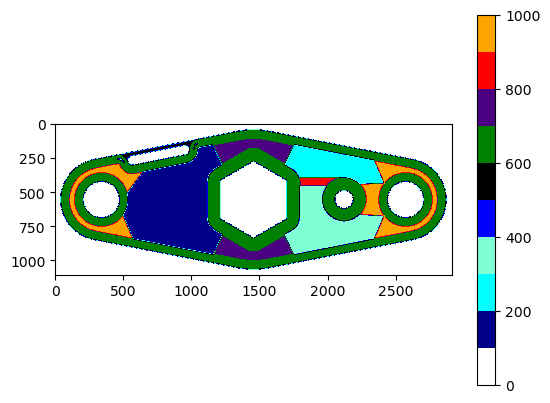

In [3]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [17]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.17070889472961426
Total de [Making offset routes] : 4.114938259124756


Rotas de pontes

In [18]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[sob_int_ext_per] = gui.ask_parameters_internal_routes()

with Timer(f"Making bridges routes"):
    for c in camadas:
        with Timer(f"Camada: {c.name}"):
            c.make_bridges_routes(folders, sob_int_ext_per)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes
Camada: L_000
Making Offset bridges routes
Total de [Making Offset bridges routes] : 0.05858564376831055
Making Zigzag bridges routes
sequncia corrigida, b e c trocado
sequncia corrigida, b e c trocado
Total de [Making Zigzag bridges routes] : 5.042899131774902
Making Crossover bridges routes
Total de [Making Crossover bridges routes] : 6.565812587738037
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.33379697799682617
Total de [Camada: L_000] : 12.7929048538208
Total de [Making bridges routes] : 12.799304485321045


Rotas de Ziguezague

In [19]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"



Making zigzag routes
criando as rotas de zigzag, camada:L_000
fazendo as tres opções:
Total de [fazendo as tres opções:] : 9.022516250610352
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.11879873275756836
fazendo as tres opções:
Total de [fazendo as tres opções:] : 7.819029331207275
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.12165307998657227
fazendo as tres opções:
Total de [fazendo as tres opções:] : 7.273081541061401
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.11787009239196777
Total de [criando as rotas de zigzag, camada:L_000] : 25.375847339630127
salvando imagens das rotas
deletado: /L_000/I_000/zigzags
Total de [salvando imagens das rotas] : 0.1518235206604004
Criando os grafos de regiões
Total de [Criando os grafos de regiões] : 0.10507607460021973
Conectando regiões de zigzag
Total de [Conectando regiões de zigzag] : 0.06426191329956055
salvando grafos
Total de [salvando grafos] : 0.14368295669555664
Total de [Making zigzag rou

WEAVING

In [20]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[iwflag] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(iwflag, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Pegando as falhas internas
Total de [Pegando as falhas internas] : 1.1946563720703125
Achando os contatos
Total de [Achando os contatos] : 7.773204326629639
criando os weavings
Total de [criando os weavings] : 5.593834161758423
Total de [gerando preenchimentos oscilatórios] : 16.962854862213135
salvando rotas
deletado: /L_000/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.14670944213867188
Total de [Fase 5 b] : 17.110349655151367


Rotas de Thin Walls

In [21]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.23746728897094727
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.031961679458618164
Total de [Making thin walls routes] : 0.26970791816711426
Total de [Fase 5] : 0.2697892189025879


Encontrando o lugar onde será o começo da trilha de cada ilha

In [22]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.islands_path_starts(folders)

%reset_selective -f "camadas"                        

Encontrando ponto de união ext-int
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.0015249252319335938
Total de [Encontrando ponto de união ext-int] : 0.17192935943603516


Unificando rotas EXTERNAS nas camadas

In [23]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 6"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 2.64300537109375
Conectando pontes de Crossover
salto:  [680, 466]
salto:  [681, 2449]
salto:  [477, 2246]
Total de [Conectando pontes de Crossover] : 2.3855764865875244
Total de [Conectando rotas externas] : 6.074020862579346
salvando imagens das rotas
deletado: /L_000/I_000/external_tree_route
Total de [salvando imagens das rotas] : 0.13676762580871582
Total de [Fase 6] : 6.211063623428345


Unificando rotas INTERNAS nas camadas

In [40]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 7"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 6.5291430950164795
Conectando pontes de zigzag
Value(False)
salto:  [842, 1696]
salto:  [172, 1762]
Total de [Conectando pontes de zigzag] : 1991.5594820976257
salvando imagens das rotas
deletado: /L_000/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 17.984651565551758
Total de [Fase 7] : 2021.9677584171295


Unindo rotas de thin walls

In [41]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 8"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 1.4693760871887207
salvando imagens das rotas
deletado: /L_000/I_000/thinwalls_tree_route/sequence
deletado: /L_000/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.1198720932006836
Total de [Fase 8] : 1.8408524990081787


Unindo todas as rotas

In [42]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.close_final_path(folders)

%reset_selective -f "camadas"


Encontrando ponto de união ext-int
Total de [Encontrando ponto de união ext-int] : 0.06252527236938477
Conectando todas as partes
Total de [Conectando todas as partes] : 0.13402366638183594
salvando imagens das rotas
deletado: /L_000/I_000/island_route
[[249, 415], [275, 281], [287, 239], [309, 195], [336, 157], [375, 118], [414, 92], [462, 71], [506, 59], [566, 56], [607, 60], [653, 73], [686, 88], [733, 118], [771, 156], [798, 194], [820, 238], [833, 284], [1007, 1173], [841, 324], [820, 238], [798, 194], [771, 156], [733, 118], [686, 88], [653, 73], [602, 59], [542, 56], [506, 59], [476, 67], [414, 92], [375, 118], [333, 161], [309, 195], [286, 242], [273, 289], [236, 479], [243, 493], [268, 518], [291, 526], [307, 541], [314, 557], [315, 576], [237, 967], [230, 980], [216, 993], [197, 1000], [172, 1000], [135, 1020], [128, 1030], [65, 1352], [56, 1417], [56, 1440], [88, 1440], [88, 1417], [96, 1359], [156, 1054], [165, 1041], [177, 1034], [217, 1028], [236, 1018], [257, 997], [269,

Gerando o Código G

In [43]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_int, vel_ext, vel_thin_wall, vel_vazio, p_religamento, p_desligamento, p_entre_int_ext, p_entre_camadas, substratoy, substratox, cortey, cortex] = gui.ask_parameters_Gcode()
coords_substrato = [substratoy, substratox]
coords_corte = [cortey, cortex]
camadas = folders.load_layers_hdf5()

#layer_heights = [10+2.9+3+(i*1.5) for i,x in enumerate(camadas)]
layer_heights = [20+8+2+(i*1.5) for i,x in enumerate(camadas)]
with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               vel_int,
                               vel_ext, 
                               vel_vazio,
                               vel_thin_wall, 
                               p_religamento,
                               p_desligamento,
                               p_entre_int_ext,
                               p_entre_camadas,
                               layer_heights,
                               coords_substrato,
                               coords_corte,
                               )
%reset_selective -f "camadas"

Cuspindo o Gcode
nome: L_000/I_000
[[249, 415], [275, 281], [287, 239], [309, 195], [336, 157], [375, 118], [414, 92], [462, 71], [506, 59], [566, 56], [607, 60], [653, 73], [686, 88], [733, 118], [771, 156], [798, 194], [820, 238], [833, 284], [1007, 1173], [841, 324], [820, 238], [798, 194], [771, 156], [733, 118], [686, 88], [653, 73], [602, 59], [542, 56], [506, 59], [476, 67], [414, 92], [375, 118], [333, 161], [309, 195], [286, 242], [273, 289], [236, 479], [243, 493], [268, 518], [291, 526], [307, 541], [314, 557], [315, 576], [237, 967], [230, 980], [216, 993], [197, 1000], [172, 1000], [135, 1020], [128, 1030], [65, 1352], [56, 1417], [56, 1440], [88, 1440], [88, 1417], [96, 1359], [156, 1054], [165, 1041], [177, 1034], [217, 1028], [236, 1018], [257, 997], [269, 971], [347, 576], [345, 550], [334, 524], [311, 501], [284, 487], [274, 473], [272, 462], [304, 296], [316, 253], [336, 212], [355, 185], [394, 144], [440, 115], [467, 103], [505, 92], [542, 88], [599, 91], [642, 103]

In [44]:
# import numpy as np
# camadas = folders.load_layers_hdf5()
# for c in camadas:
#     folders.load_islands_hdf5(c)
#     for isl in c.islands:
#         folders.load_island_paths_hdf5(c.name, isl)
#         internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
#         print(internal_trees)
# print([235,807] in internal_trees)

In [45]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [46]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)

In [47]:
# class TrafficLightState:
#     """Base class for traffic light states."""
#     def change(self, traffic_light):
#         raise NotImplementedError("This method should be overridden by subclasses")


# class RedState(TrafficLightState):
#     """State representing the red light."""
#     def change(self, traffic_light):
#         print("Changing from Red to Green")
#         traffic_light.state = GreenState()


# class YellowState(TrafficLightState):
#     """State representing the yellow light."""
#     def change(self, traffic_light):
#         print("Changing from Yellow to Red")
#         traffic_light.state = RedState()


# class GreenState(TrafficLightState):
#     """State representing the green light."""
#     def change(self, traffic_light):
#         print("Changing from Green to Yellow")
#         traffic_light.state = YellowState()


# class TrafficLight:
#     """Traffic light class that uses a state machine."""
#     def __init__(self):
#         self.state = RedState()  # Initial state

#     def change(self):
#         """Change the state of the traffic light."""
#         self.state.change(self)

#     def __str__(self):
#         return f"Current state: {self.state.__class__.__name__}"


# # Example usage
# if __name__ == "__main__":
#     traffic_light = TrafficLight()
    
#     # Simulate the traffic light changing states
#     for _ in range(6):  # Change state 6 times
#         print(traffic_light)
#         traffic_light.change()

In [48]:
# import numpy as np
# import cv2  # Assuming you are using OpenCV for image processing

# def bobobo(image1, image2):
#     """A placeholder function that performs some operation on two images."""
#     # For demonstration, let's just return the absolute difference between the two images
#     return cv2.absdiff(image1, image2)

# def process_images(image_list):
#     """Process a list of images, comparing the last two with the current image."""
#     for i in range(len(image_list)):
#         current_image = image_list[i]
        
#         # Check if there are at least two previous images to compare
#         if i >= 2:
#             last_image = image_list[i - 1]
#             second_last_image = image_list[i - 2]
            
#             # Apply the bobobo function to the current image and the last two images
#             result_last = bobobo(current_image, last_image)
#             result_second_last = bobobo(current_image, second_last_image)
            
#             # Here you can do something with the results, like saving or displaying them
#             # For demonstration, we'll just print the shapes of the results
#             print(f"Comparing image {i} with last image {i-1}: result shape = {result_last.shape}")
#             print(f"Comparing image {i} with second last image {i-2}: result shape = {result_second_last.shape}")

# # Example usage
# if __name__ == "__main__":
#     # Create a list of dummy images (for demonstration purposes)
#     # In practice, you would load your images using cv2.imread or similar
#     image_list = [np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8) for _ in range(5)]
    
#     process_images(image_list)